In [1]:
!pip install azure-cli
!pip install pydicom azure.identity
!pip install requests_toolbelt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 856 kB 55.1 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 230 kB 53.0 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 59 kB 5.4 MB/s 
     |████████████████████████████████| 484 kB 50.2 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 2.3 MB 35.6 MB/s 
     |████████████████████████████████| 4.2 MB 36.2 MB/s 
     |████████████████████████████████| 61 kB 292 kB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 231 kB 48.4 MB/s 
     |████████████████████████████████| 43 kB 1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
     |████████████████████████████████| 136 kB 52.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.4 MB/s 


In [2]:
import requests
import pydicom
from pathlib import Path
from urllib3.filepost import encode_multipart_formdata, choose_boundary
from azure.identity import DefaultAzureCredential
import matplotlib.pylab as plt

In [3]:
!az login

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code AY748VXTQ to authenticate.
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "e056658c-7855-40e3-9a64-9a8c4fe82c9a",
    "id": "c7518a1a-6651-45cb-8726-8fd7cf93e0cb",
    "isDefault": true,
    "managedByTenants": [],
    "name": "Azure for Students",
    "state": "Enabled",
    "tenantId": "e056658c-7855-40e3-9a64-9a8c4fe82c9a",
    "user": {
      "name": "spp26041999@gmail.com",
      "type": "user"
    }
  }
]


In [4]:
base_url = f"https://mammogram-mammogram.dicom.azurehealthcareapis.com/v1"

https://docs.microsoft.com/en-us/azure/healthcare-apis/dicom/dicomweb-standard-apis-python

In [5]:
credential = DefaultAzureCredential()

#print(credential.credentials) # this can be used to find the index of the AzureCliCredential
token = credential.credentials[4].get_token('https://dicom.healthcareapis.azure.com')
bearer_token = f'Bearer {token.token}'

In [6]:
def encode_multipart_related(fields, boundary=None):
    if boundary is None:
        boundary = choose_boundary()

    body, _ = encode_multipart_formdata(fields, boundary)
    content_type = str('multipart/related; boundary=%s' % boundary)

    return body, content_type

In [7]:
client = requests.session()

In [8]:
headers = {"Authorization":bearer_token}
url= f'{base_url}/changefeed'

response = client.get(url,headers=headers)
if (response.status_code != 200):
    print('Error! Likely not authenticated!')
else:
  print("Success")

Success


In [9]:
# #upload blue-circle.dcm
# filepath = Path("/content").joinpath('1-1.dcm')

# # Open up and read through file and load bytes into memory 
# with open(filepath,'rb') as reader:
#     body = reader.read()

# headers = {'Accept':'application/dicom+json', 'Content-Type':'application/dicom', "Authorization":bearer_token}

# url = f'{base_url}/studies'
# response = client.post(url, body, headers=headers, verify=False)
# response  # response should be a 409 Conflict if the file was already uploaded in the above request

In [10]:
url = f'{base_url}/studies/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009'
headers = {'Accept':'multipart/related; type="application/dicom"; transfer-syntax=*', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 396, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/response.py", line 72, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''


In [11]:
response

<Response [200]>

b'application/dicom; transfer-syntax=1.2.840.10008.1.2'


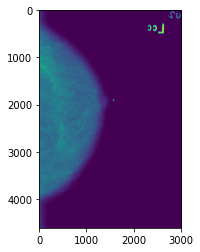

In [12]:
import requests_toolbelt as tb
from io import BytesIO

mpd = tb.MultipartDecoder.from_response(response)
for part in mpd.parts:
    # Note that the headers are returned as binary!
    print(part.headers[b'content-type'])
    
    # You can convert the binary body (of each part) into a pydicom DataSet
    #   And get direct access to the various underlying fields
    ds = pydicom.dcmread(BytesIO(part.content))
    plt.imshow(ds.pixel_array)

    # dcm = pydicom.dcmread(BytesIO(part.content))
    # print(dcm.PatientName)
    # print(dcm.SOPInstanceUID)

In [13]:
url = f'{base_url}/studies/1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009/metadata'
headers = {'Accept':'application/dicom+json', "Authorization":bearer_token}

response = client.get(url, headers=headers) #, verify=False)
response.text

'[{"00080005":{"vr":"CS","Value":["ISO_IR 100"]},"00080016":{"vr":"UI","Value":["1.2.840.10008.5.1.4.1.1.7"]},"00080018":{"vr":"UI","Value":["1.3.6.1.4.1.9590.100.1.2.289923739312470966435676008311959891294"]},"00080020":{"vr":"DA"},"00080023":{"vr":"DA","Value":["20160503"]},"00080030":{"vr":"TM"},"00080033":{"vr":"TM","Value":["105946.779000"]},"00080050":{"vr":"SH"},"00080060":{"vr":"CS","Value":["MG"]},"00080064":{"vr":"CS","Value":["WSD"]},"00080090":{"vr":"PN"},"00100010":{"vr":"PN","Value":[{"Alphabetic":"P_00038^P_00038"}]},"00100020":{"vr":"LO","Value":["P_00038_LEFT_CC.dcm"]},"00100030":{"vr":"DA"},"00100040":{"vr":"CS"},"00180015":{"vr":"CS","Value":["Left Breast"]},"00181016":{"vr":"LO","Value":["MathWorks"]},"00181018":{"vr":"LO","Value":["MATLAB"]},"0020000D":{"vr":"UI","Value":["1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009"]},"0020000E":{"vr":"UI","Value":["1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992"]},"00200010":{"vr":"SH","Value